In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pyramid
from pmdarima.arima import auto_arima

In [3]:
data=pd.read_csv("daily-total-female-births-CA.csv")

In [4]:
data.head()

,date,births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


In [5]:
data.tail()

,date,births
360,1959-12-27,37
361,1959-12-28,52
362,1959-12-29,48
363,1959-12-30,55
364,1959-12-31,50


In [6]:
data["date"]=pd.to_datetime(data["date"],infer_datetime_format=True)

In [7]:
data.set_index("date",inplace=True)

In [8]:
data.head()

,births
date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [34]:
data.tail(5)

,births
date,
1959-12-27,37
1959-12-28,52
1959-12-29,48
1959-12-30,55
1959-12-31,50


### Rolling Statistics and Dickey-Fuller Test (ADF)

In [13]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd =  timeseries.rolling(7).std()

    #Plot rolling statistics:
    plt.rcParams["figure.figsize"] = (18, 10)
    plt.xticks(rotation=90, ha='right')
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

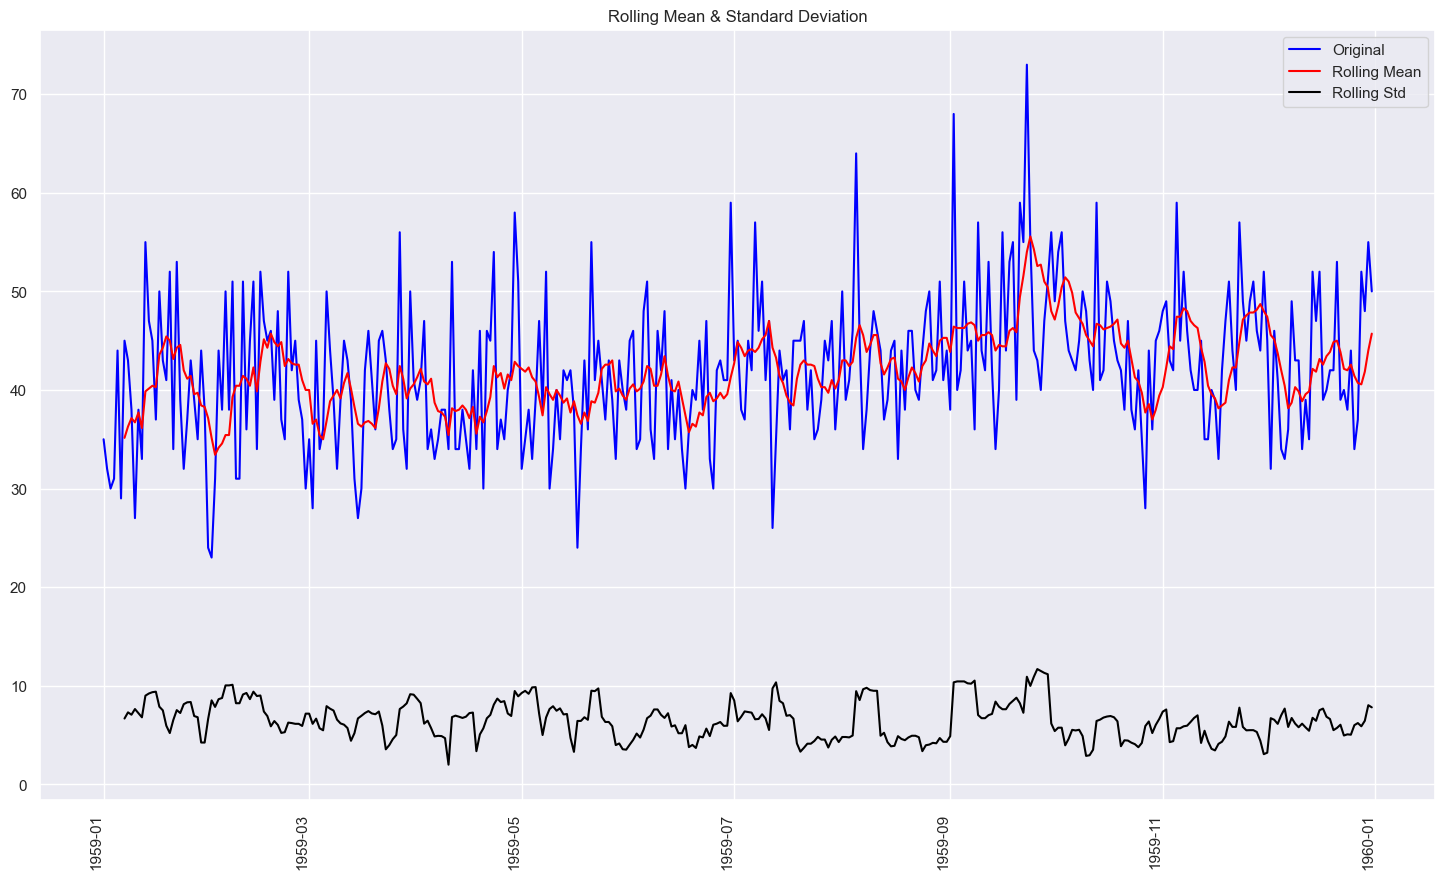

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


In [14]:
test_stationarity(data)

#### As p-value is less than 0.05, this timeseries data is stationary. Rolling mean and standard deivation also looks constant

### Decomposing data into Trend, Seasonality and Residuals

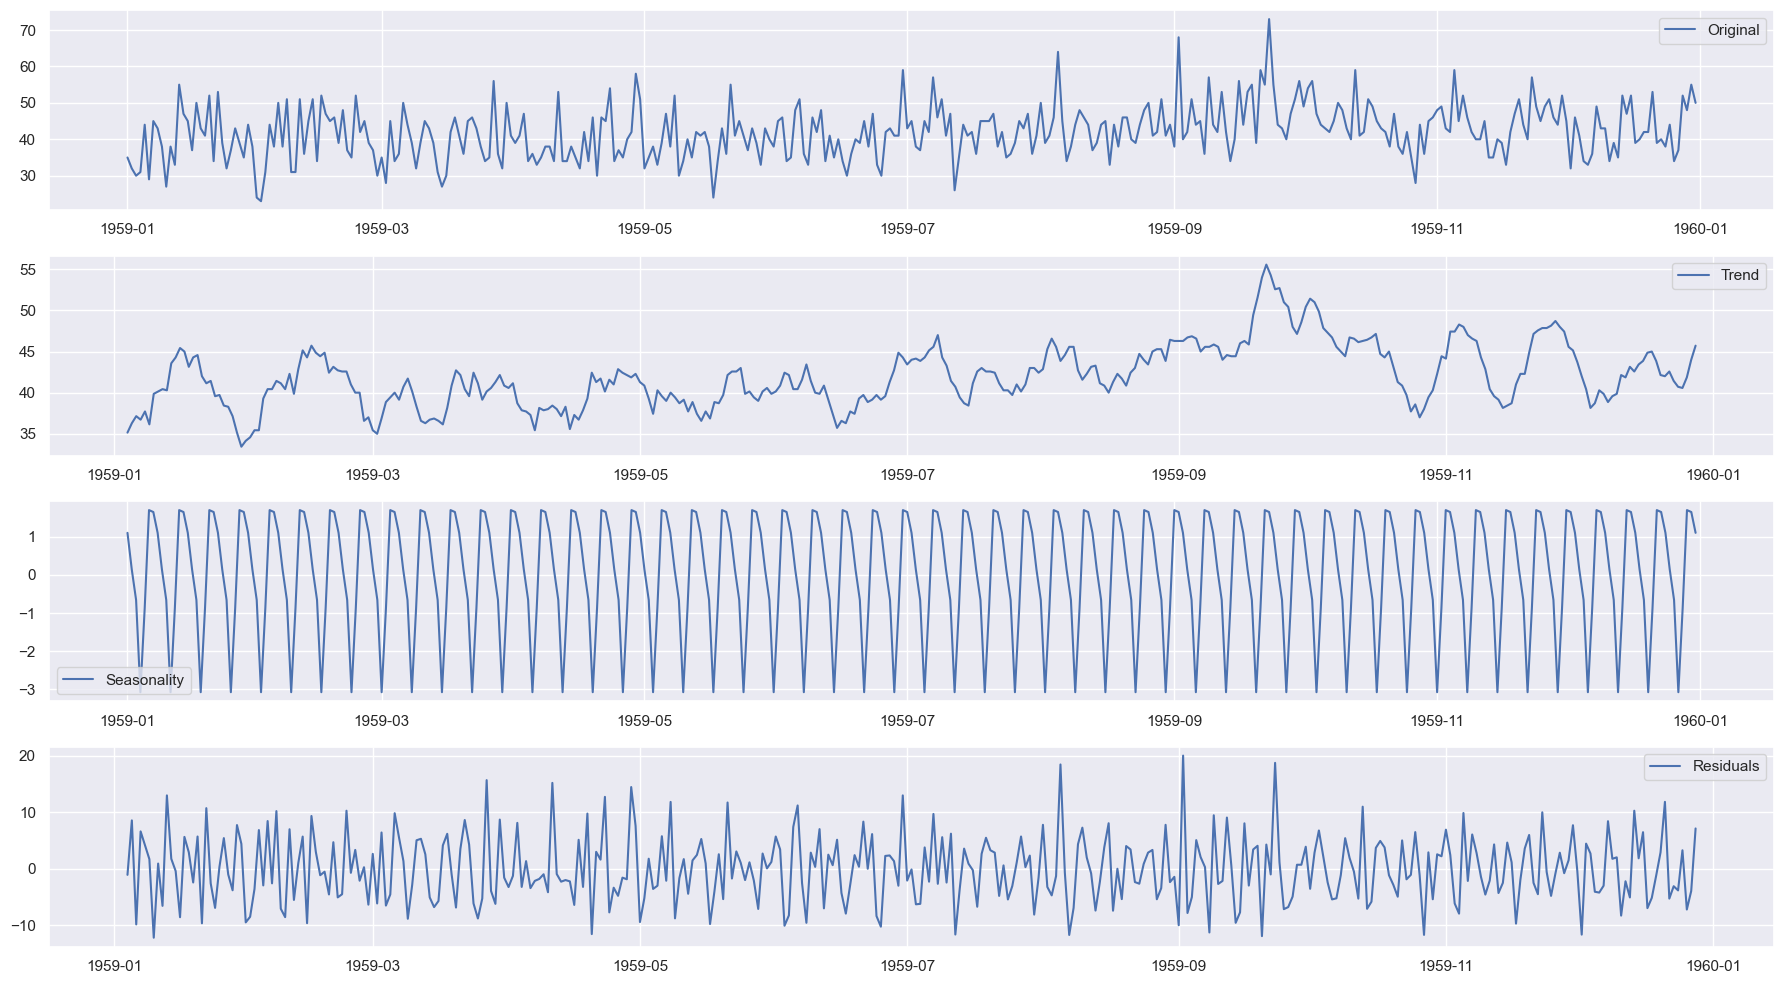

In [22]:
decomposition = seasonal_decompose(data,period=7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.xticks(rotation=90, ha='right')
plt.subplot(411)
plt.plot(data, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Applying Forecasting Model --> Auto-Arima

In [26]:
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())
stepwise_model.fit(data)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=2806.298, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=2635.646, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=2713.038, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=2558.991, Time=0.12 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=0.71 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=2654.360, Time=0.11 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=2530.962, Time=0.18 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=2605.454, Time=0.11 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=0.71 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=0.48 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=2510.987, Time=0.28 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=2592.615, Time=0.14 s

ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 7),
      suppress_warnings=True, with_intercept=False)

In [27]:
Predicted_values=stepwise_model.fittedvalues()
Predicted_values=pd.DataFrame(Predicted_values,columns=['Prediction'])

### Forecasting values for next 7 days

In [29]:
Forecasted_values=stepwise_model.predict(7)
Forecasted_values=pd.DataFrame(Forecasted_values,columns=['Prediction'])

In [30]:
Consolidated_predicted_values=pd.concat([Predicted_values,Forecasted_values],axis=0)

In [37]:
Consolidated_predicted_values.tail(15)

,Prediction
1959-12-24,42.337496
1959-12-25,37.092838
1959-12-26,35.813622
1959-12-27,35.360518
1959-12-28,43.773377
1959-12-29,47.850912
1959-12-30,45.540917
1959-12-31,46.190600
1960-01-01,46.686031
1960-01-02,45.636533


<Axes: >

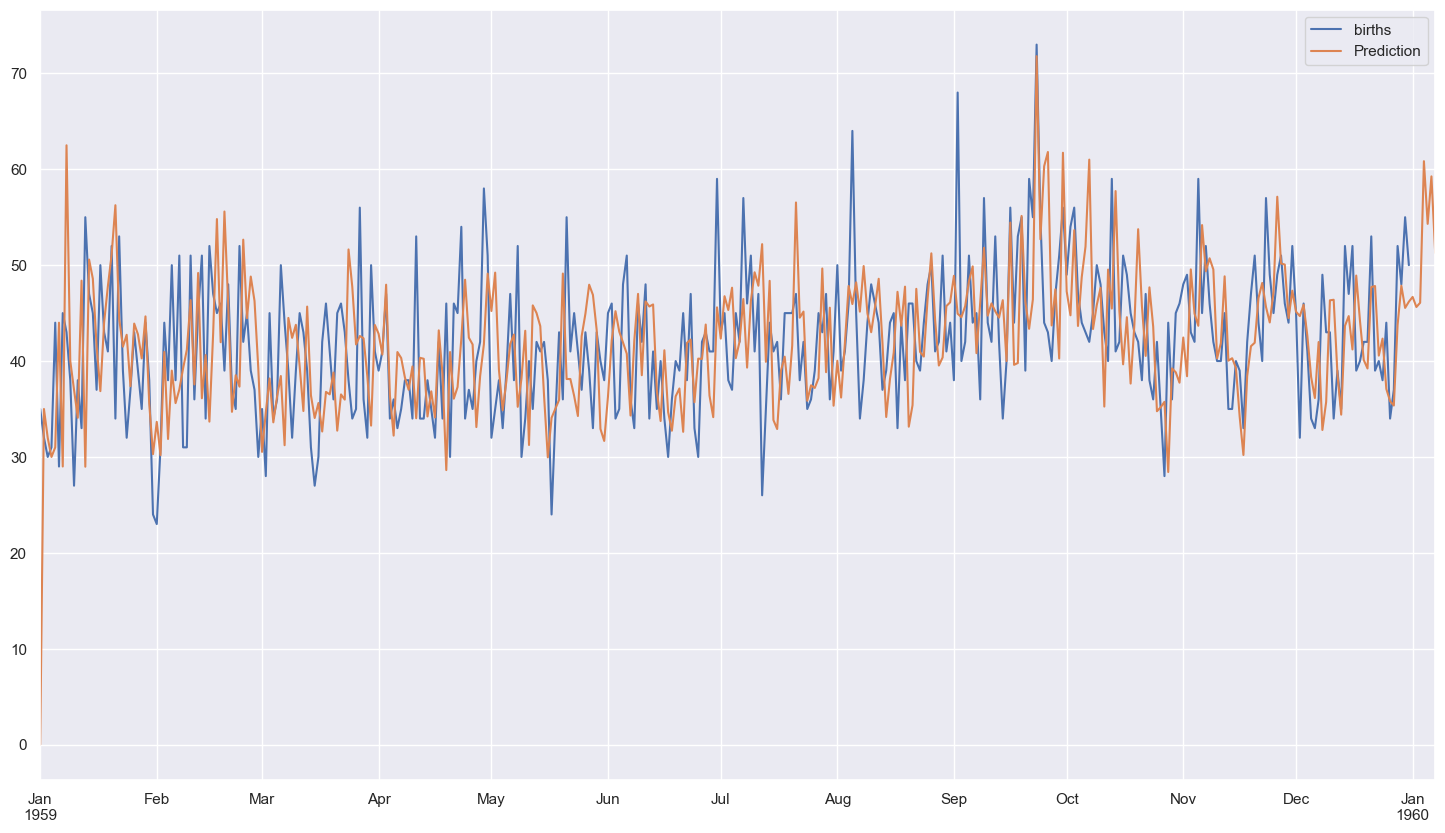

In [35]:
pd.concat([data,Consolidated_predicted_values],axis=1).plot()